<a href="https://colab.research.google.com/github/lucas-azdias/Artistic-Text-Recognition/blob/main/artefatos/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fazer finetuning para cada modelo + comparar erros entre modelos raw e tuned (pode servir com extra no ensemble)
# Analisar erros do ensemble com finetuning sobre validacao e fazer data augmentation

In [ ]:
# Criar condaEnv e passar com param do Model (para compartilhar)

# Configurações

## Importações

In [ ]:
import abc
import dataclasses
import json
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import PIL
import sys
import torch
import torchvision
import tqdm
import typing

## Instalando Miniconda

In [ ]:
!wget -q -O Miniconda.sh https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda.sh -b -f -p miniconda > /dev/null
!rm Miniconda.sh

!sudo rm -f /usr/local/bin/conda
!ln -s /content/miniconda/bin/conda /usr/local/bin/conda

!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main
!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r

accepted Terms of Service for https://repo.anaconda.com/pkgs/main
accepted Terms of Service for https://repo.anaconda.com/pkgs/r


## Componentes auxiliares

### Classes auxiliares

In [ ]:
# Classe para resultados completos de predições
@dataclasses.dataclass
class Prediction:
    path: pathlib.Path
    true: str
    pred: str
    confidence: tuple[float, ...]

In [ ]:
# Classe para resultados parciais de predições
@dataclasses.dataclass
class RawPrediction:
    path: pathlib.Path
    pred: str
    confidence: tuple[float, ...]

In [ ]:
# Classe para resultados de predições de um modelo
@dataclasses.dataclass
class EnsembleModelPrediction:
    pred: str
    confidence: tuple[float, ...]

In [ ]:
# Classe para resultados de predições de vários modelos
@dataclasses.dataclass
class EnsemblePrediction:
    path: pathlib.Path
    true: str
    models_preds: list[EnsembleModelPrediction]
    pred: typing.Optional[str] = None
    confidence: typing.Optional[tuple[float, ...]] = None

In [ ]:
# Classe para itens no dataset
@dataclasses.dataclass
class DatasetItem:
    path: pathlib.Path
    label: str

In [ ]:
# Classe para criar ambiente Conda e rodar comandos passados
class CondaEnv:
    def __init__(self, name: str, python_version: str, config_cmds: list[str], path: typing.Optional[pathlib.Path] = None) -> None:
        self.__name = name
        self.__python_version = python_version

        # Caso haja caminho, substitua ele nos comandos
        if path:
            config_cmds = [
                config_cmd.replace("{}", str(path.absolute()))
                for config_cmd in config_cmds
            ]

        # Cria ambiente
        !conda env remove -n "{self.name}" -y -q > /dev/null 2>&1
        !conda create -n "{self.name}" python={python_version} -y -q > /dev/null 2>&1

        # Roda comandos de configuração
        for config_cmd in config_cmds:
            !conda run -n "{self.name}" {config_cmd} > /dev/null 2>&1

    @property
    def name(self) -> str:
        return self.__name

    @property
    def python_version(self) -> str:
        return self.__python_version

    # Função para executar um comando dentro de um ambiente Conda
    def run(self, cmd: str, cd: typing.Optional[str | pathlib.Path] = None, ignore_output: bool = False) -> None:
        !cd {cd if cd else "."} && conda run -n "{self.name}" {cmd}{" > /dev/null 2>&1" if ignore_output else ""}

In [ ]:
# Classe para repositórios
class Repo:
    def __init__(self, url: str, path: pathlib.Path) -> None:
        self.__url = url
        self.__path = path

        # Obtém repositório
        pull_repo(self.url, self.path)

    @property
    def url(self) -> str:
        return self.__url

    @property
    def path(self) -> pathlib.Path:
        return self.__path

In [ ]:
# Classe para criar modelos
class Model(abc.ABC):
    def __init__(self, name: str, conda_env: CondaEnv, repo: Repo, should_use_tuned: bool = False) -> None:
        self.__name = name
        self.__should_use_tuned = should_use_tuned
        self.__conda_env = conda_env
        self.__repo = repo

    @property
    def name(self) -> str:
        return self.__name

    @property
    def should_use_tuned(self) -> bool:
        return self.__should_use_tuned

    @property
    def path(self) -> pathlib.Path:
        return self.__repo.path

    def pretrained_weights(self) -> str:
        return str((pretrained_path / f"{self.name}").absolute())

    def tuned_weights(self) -> str:
        return str((tuned_path / f"{self.name}").absolute())

    def run(self, cmd: str, cd: typing.Optional[str | pathlib.Path] = None, ignore_output: bool = False) -> None:
        self.__conda_env.run(cmd, cd, ignore_output)

    @abc.abstractmethod
    def infer(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem]) -> list[Prediction]:
        pass

### Funções auxiliares

In [ ]:
# Função para reiniciar caminho
def reset_path(path: pathlib.Path) -> None:
    !rm -rf "{path}"
    !mkdir -p "{path}"

In [ ]:
# Função para obter repositório
def pull_repo(url: str, path: pathlib.Path) -> None:
    # Clonar o repositório
    !rm -rf "{path}"
    !git clone -q "{url}" "{path}"

    if not str(path.absolute()) in sys.path:
        sys.path.append(str(path.absolute()))

In [ ]:
# Função para alterar trechos dos arquivos alvos
def modify_target_files(target_files: list[pathlib.Path], old_texts: list[str], new_texts: list[str]) -> None:
    for target_file in target_files:
        text = target_file.read_text(encoding="utf-8")

        for old_text, new_text in zip(old_texts, new_texts):
            text = text.replace(
                old_text,
                new_text
            )

        target_file.write_text(text, encoding="utf-8")

In [ ]:
# Função para definir nome do arquivo com resultados
def get_results_name(name: str) -> str:
    return f"{name}_predictions.txt"

In [ ]:
# Função para escrever arquivo com resultados
def write_results(
        name: str,
        results: list[Prediction]
    ) -> None:
    data = []
    for result in results:
        data.append({
            "path": result.path,
            "true": result.true,
            "pred": result.pred,
            "confidence": result.confidence
        })

    results_name = get_results_name(name)

    with open(results_name, "x") as file:
        json.dump(data, file, indent=4)

In [ ]:
# Função para ler os resultados do arquivo
def read_results(
    name: str
) -> list[Prediction]:
    results_name = get_results_name(name)

    # Verifica se o arquivo existe
    if not pathlib.Path(results_name).exists():
        raise FileNotFoundError(f"O arquivo {results_name} não foi encontrado.")

    # Abre e carrega o conteúdo JSON
    with open(results_name, "r") as file:
        data = json.load(file)

    # Recupera os dados
    results: list[Prediction] = []
    for item in data:
        results.append(Prediction(
            path=pathlib.Path(item["path"]),
            true=item["true"],
            pred=item["pred"],
            confidence=item["confidence"]
        ))

    return results

In [ ]:
# Função para formatar uma coleção de predições
def format_raw_results(raw_results: list[RawPrediction], dataset_items: list[DatasetItem]) -> list[Prediction]:
    results: list[Prediction] = []
    for dataset_item in dataset_items:
        for raw_prediction in raw_results:
            if dataset_item.path.stem == raw_prediction.path.stem:
                results.append(Prediction(
                    path=raw_prediction.path,
                    true=dataset_item.label,
                    pred=raw_prediction.pred,
                    confidence=raw_prediction.confidence
                ))
                break

    return results

## Obtendo *dataset*

### Obtendo repositório

In [ ]:
# Obtendo repositório
dataset_path = pathlib.Path("/content/WordArt-V1.5")

pull_repo(
    "https://github.com/lucas-azdias/Artistic-Text-Recognition-Dataset.git",
    dataset_path
)

### Carregando partições do *dataset*

In [ ]:
# Lista todos as partições de datasets
dataset_names = [p.name for p in dataset_path.iterdir() if p.is_dir() and not p.name in [".git", "utils"]]

print(dataset_names)

['testA', 'testB', 'train']


In [ ]:
def load_data(base_path: pathlib.Path, name: str) -> tuple[list[pathlib.Path], list[str]]:
    labels_path = pathlib.Path(base_path, name, "labels.txt")

    image_paths = []
    classes = []

    with open(labels_path, "r") as f:
        for line in f:
            # Ex: "train_image\320.png Ford"
            splitted = line.strip().split(" ")
            path, label = splitted[0].replace("\\", "/"), " ".join(splitted[1:])

            # Ajustar o caminho para apontar para a pasta correta
            img_path = pathlib.Path(base_path, name, pathlib.Path(path))
            image_paths.append(img_path)
            classes.append(label)

    return image_paths, classes

In [ ]:
dataset_items: dict[str, list[DatasetItem]] = {}

for dataset_name in dataset_names:
    images, labels = load_data(dataset_path, dataset_name)
    dataset_items[dataset_name] = [
        DatasetItem(
            path=image,
            label=label
        )
        for image, label in zip(images, labels)
    ]

## Obtendo os modelos

### Caminhos para pesos dos modelos

In [ ]:
# Pesos pré-treinados
pretrained_path = pathlib.Path("/content/weights/pretrained")
reset_path(pretrained_path)

In [ ]:
# Pesos com fine-tuning
tuned_path = pathlib.Path("/content/weights/tuned")
reset_path(tuned_path)

### PARSeq

In [ ]:
# Classe do modelo PARSeq
class ParseqModel(Model):
    def pretrained_weights(self) -> str:
        return "pretrained=parseq"

    def tuned_weights(self) -> str:
        return super().tuned_weights() + ".ckpt"

    def infer(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem]) -> list[Prediction]:
        self.run(
            cmd=f"python \"{self.path}/read.py\" \
            {self.tuned_weights() if self.should_use_tuned else self.pretrained_weights()} \
            --images=\"{imgs_path}\" \
            --device=cuda",
            cd=self.path,
            ignore_output=True
        )

        with open(f"{self.path}/outputs.txt") as file:
            raw_results = file.read().strip().split("\n")

        raw_results = [line.strip().split("\t") for line in raw_results]
        raw_results = [
            RawPrediction(
                path=pathlib.Path(path),
                pred=pred,
                confidence=tuple([
                    float(c)
                    for c in confidence.replace("[", "").replace("]", "").strip().split(", ")
                ])
            )
            for path, pred, confidence in raw_results
        ]

        results = format_raw_results(raw_results, dataset_items)

        return results

In [ ]:
parseq_repo = Repo(
    url="https://github.com/baudm/parseq.git",
    path=pathlib.Path("/content/parseq")
)

In [ ]:
parseq_env = CondaEnv(
    name="parseq",
    python_version="3.10",
    config_cmds=[
        "pip install pip-tools",
        "make torch-cu121 -C {}",
        "pip install -qq -r \"{}/requirements/core.cu121.txt\" -e {}/.[bench,train,test] --use-pep517",
    ],
    path=parseq_repo.path
)

In [ ]:
parseq_model = ParseqModel(
    name="parseq",
    conda_env=parseq_env,
    repo=parseq_repo
)

In [ ]:
tuned_parseq_model = ParseqModel(
    name="parseq",
    conda_env=parseq_env,
    repo=parseq_repo,
    should_use_tuned=True
)

In [ ]:
# Modificando trechos necessários
modify_target_files(
    [
        parseq_model.path / "read.py",
    ],
    [
        "import argparse",
        "nargs='+', ",
        "for fname in args.images:",
        "Image.open(fname)",
        "print(f'{fname}: {pred[0]}')",
    ],
    [
        "import argparse\nfrom pathlib import Path",
        "",
        "text = \"\"\n    imgs = Path(args.images)\n    for fname in (imgs.rglob(\"*\") if imgs.is_dir() else [imgs]):",
        "Image.open(fname.absolute())",
        "text += f\"{fname}\t{pred[0]}\t{p[0].tolist()[:-1]}\\n\"\n    print(text)\n    open(\"outputs.txt\", \"w\").write(text)",
    ],
)

### SVTRv2

In [ ]:
# Classe do modelo SVTRv2
class Svtrv2Model(Model):
    def pretrained_weights(self) -> str:
        return super().pretrained_weights() + ".pth"

    def tuned_weights(self) -> str:
        return super().tuned_weights() + ".pth"

    def infer(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem]) -> list[Prediction]:
        self.run(
            cmd=f"python \"{self.path}/tools/infer_rec.py\" \
            --c \"{self.path}/configs/rec/svtrv2/svtrv2_smtr_gtc_rctc_infer.yml\" \
            --o \
                Global.infer_img=\"{imgs_path}\" \
                Global.output_dir=\"./output/rec/u14m_filter/svtrv2_smtr_gtc_rctc\" \
                Global.pretrained_model=\"{self.tuned_weights() if self.should_use_tuned else self.pretrained_weights()}\" \
                Global.checkpoints=\"null\"",
            cd=self.path,
            ignore_output=True
        )

        with open(f"{self.path}/rec_results/rec_results.txt") as file:
            raw_results = file.read().strip().replace("\n/", "\n//").split("\n/")

        raw_results = [line.strip().split("\t") for line in raw_results]
        raw_results = [
            RawPrediction(
                path=pathlib.Path(path),
                pred=pred,
                confidence=tuple([
                    float(c)
                    for c in confidence.replace("\n", "").replace("[", "").replace("]", "").strip().split()
                ])
            )
            for path, pred, confidence in raw_results
        ]

        results = format_raw_results(raw_results, dataset_items)

        return results

In [ ]:
svtrv2_repo = Repo(
    url="https://github.com/Topdu/OpenOCR.git",
    path=pathlib.Path("/content/svtrv2")
)

In [ ]:
svtrv2_env = CondaEnv(
    name="svtrv2",
    python_version="3.8",
    config_cmds=[
        "pip install torch==2.2.0+cu118 torchvision==0.17.0+cu118 torchaudio==2.2.0 --extra-index-url https://download.pytorch.org/whl/cu118",
        "pip install -r \"{}/requirements.txt\"",
    ],
    path=svtrv2_repo.path
)

In [ ]:
svtrv2_model = Svtrv2Model(
    name="svtrv2",
    conda_env=svtrv2_env,
    repo=svtrv2_repo
)

In [ ]:
tuned_svtrv2_model = Svtrv2Model(
    name="svtrv2",
    conda_env=svtrv2_env,
    repo=svtrv2_repo,
    should_use_tuned=True
)

In [ ]:
# Obtendo pesos pré-treinados
!gdown -q 1P56B_PVYBF649zUqQFShuAZC1XuNmUcL -O "{svtrv2_model.pretrained_weights()}"

In [ ]:
# Modificando trechos necessários
modify_target_files(
    [
        svtrv2_model.path / "openrec" / "postprocess" / "ctc_postprocess.py",
        svtrv2_model.path / "openrec" / "postprocess" / "smtr_postprocess.py",
    ],
    [
        "result_list.append((text, np.mean(conf_list).tolist()))",
    ],
    [
        "result_list.append((text, conf_list))",
    ]
)

### MAERec

In [ ]:
# Classe do modelo MAERec
class MaerecModel(Model):
    def pretrained_weights(self) -> str:
        return super().pretrained_weights() + ".pth"

    def tuned_weights(self) -> str:
        return super().tuned_weights() + ".pth"

    def infer(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem]) -> list[Prediction]:
        output_path = self.path / "output"

        reset_path(output_path)

        self.run(
            cmd=f"python \"tools/infer.py\" \
            \"{imgs_path}\" \
            --batch-size 256 \
            --out-dir \"{self.path}/output\" \
            --rec \"configs/textrecog/maerec/maerec_b_union14m.py\" \
            --rec-weights \"{self.tuned_weights() if self.should_use_tuned else self.pretrained_weights()}\" \
            --device cuda \
            --show \
            --save_pred",
            cd=self.path / "mmocr-dev-1.x",
            ignore_output=True
        )

        raw_results: list[RawPrediction] = []
        for json_file in (self.path / "output").rglob("*.json"):
            with open(json_file, "r", encoding="utf-8") as file:
                data = json.load(file)
            raw_results.append(
                RawPrediction(
                    path=pathlib.Path(json_file),
                    pred=str(data["rec_texts"][0]),
                    confidence=tuple([float(x) for x in data["rec_scores"][0]])
                )
            )

        results = format_raw_results(raw_results, dataset_items)

        return results

In [ ]:
maerec_repo = Repo(
    url="https://github.com/Mountchicken/Union14M.git",
    path=pathlib.Path("/content/maerec")
)

In [ ]:
maerec_env = CondaEnv(
    name="maerec",
    python_version="3.8",
    config_cmds=[
        "pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html",
        "pip install -U openmim timm matplotlib_inline ipython",
        "mim install mmengine mmcv==2.0.0 mmdet==3.0.0",
        "pip install -r \"{}/mmocr-dev-1.x/requirements/albu.txt\"",
        "pip install -r \"{}/mmocr-dev-1.x/requirements.txt\"",
        "pip install -v -e \"{}/mmocr-dev-1.x/.\" --config-settings editable_mode=compat",
    ],
    path=maerec_repo.path
)

In [ ]:
maerec_model = MaerecModel(
    name="maerec",
    conda_env=maerec_env,
    repo=maerec_repo
)

In [ ]:
tuned_maerec_model = MaerecModel(
    name="maerec",
    conda_env=maerec_env,
    repo=maerec_repo,
    should_use_tuned=True
)

In [ ]:
# Obtendo pesos pré-treinados
!gdown -q 13E0cmvksKwvjNuR62xZhwkg8eQJfb_Hp -O "{maerec_model.pretrained_weights()}"

In [ ]:
# Modificando trechos necessários
modify_target_files(
    [
        maerec_model.path / "mmocr-dev-1.x" / "mmocr" / "apis" / "inferencers" / "textrec_inferencer.py",
    ],
    [
        "result['scores'] = float(np.mean(score))",
    ],
    [
        "result['scores'] = score",
    ]
)

In [ ]:
# Configurando variáveis de ambiente
%set_env NO_ALBUMENTATIONS_UPDATE=1

env: NO_ALBUMENTATIONS_UPDATE=1


## Criando o *ensemble*

### *Ensemble*

In [ ]:
class Ensemble:
    def __init__(
            self,
            models: list[Model],
            strategies: list[typing.Callable[[EnsemblePrediction], EnsemblePrediction]],
            prioritized_model: int = 0
        ) -> None:
        self.__models = models
        self.__strategies = strategies

        print("Modelos do ensemble:")
        for model in models:
            print(f"\t{model.name} ({'Com ajuste fino' if model.should_use_tuned else 'Pré-treinado'})")

        print("\nEstratégias do ensemble:")
        for strategy in strategies:
            if not callable(strategy):
                raise TypeError(f"Estratégia inválida: {strategy} (não é uma função)")

            if not hasattr(strategy, "__name__"):
                raise TypeError(f"Estratégia {strategy} não possui nome")

            print(f"\t{strategy.__name__}")

    def run(self, imgs_path: pathlib.Path, dataset_items: list[DatasetItem]) -> list[EnsemblePrediction]:
        # Prediz para todos os modelos
        # models_predictions = [
        #     model.infer(imgs_path, dataset_items)
        #     for model in self.__models
        # ]

        # Transpõe as predições
        models_predictions_transposed: list[tuple[Prediction, ...]] = list(map(tuple, zip(*models_predictions)))

        # Calcula fator de correção para confianças dos modelos
        models_factor = [
            np.mean([
                np.mean(pred.confidence)
                for pred in models_prediction
            ])
            for models_prediction in models_predictions
        ]

        # Aplica fator de correção
        models_predictions_transposed = [
            tuple(
                Prediction(
                    path=model_prediction.path,
                    true=model_prediction.true,
                    pred=model_prediction.pred,
                    confidence=tuple(
                        conf * factor
                        for conf in model_prediction.confidence
                    )
                ) for model_prediction, factor in zip(models_prediction, models_factor)
            ) for models_prediction in models_predictions_transposed
        ]

        # Extrae valores em comum
        models_predictions_combined: list[EnsemblePrediction] = [
            EnsemblePrediction(
                path=models_prediction[0].path,
                true=models_prediction[0].true,
                models_preds=[
                    EnsembleModelPrediction(
                        pred=p.pred,
                        confidence=p.confidence
                    )
                    for p in models_prediction
                ],
            )
            for models_prediction in models_predictions_transposed
        ]

        results: list[EnsemblePrediction] = []

        # Para cada predição, executa a sequência de estratégias
        for models_prediction in tqdm.tqdm(models_predictions_combined, desc="Ensemble", total=len(models_predictions_combined)):
            for strategy in self.__strategies:
                models_prediction = strategy(models_prediction)

            results.append(models_prediction)

        return results

### Estratégias para o *ensemble*

#### Estratégia de eleição por confiança mínima

In [ ]:
def min_confidence_strategy(models_prediction: EnsemblePrediction) -> EnsemblePrediction:
    # Detecta posições com desacordo
    max_len = max(len(model_pred.pred) for model_pred in models_prediction.models_preds)
    different_indexes = [
        i for i in range(max_len)
        if len({model_pred.pred[i]
        if i < len(model_pred.pred) else None
        for model_pred in models_prediction.models_preds}) > 1
    ]

    # Calcula pontuação por modelo
    model_scores: list[float] = []
    for model_pred in models_prediction.models_preds:
        if different_indexes:
            vals = [
                model_pred.confidence[i]
                for i in different_indexes if i < len(model_pred.confidence)
            ]
        else:
            vals = model_pred.confidence
        score = min(vals) if vals else 0.0 # Score como confiança mínima
        model_scores.append(score)

    # Escolhe melhor modelo (maior pontuação)
    best_model_idx = max(range(len(model_scores)), key=lambda i: model_scores[i])
    best_pred = models_prediction.models_preds[best_model_idx]

    # Registra predição
    models_prediction.pred = best_pred.pred
    models_prediction.confidence = best_pred.confidence

    return models_prediction

#### Estratégia de eleição por caractere com Needleman-Wunsch

In [ ]:
# Função para alinhamento global de Needleman-Wunsch com penalidades afins por gaps
def needleman_wunsch(
    s1: str,
    s2: str,
    match_score: int = 2,
    mismatch_cost: int = -2,
    gap_open: float = -1,
    gap_extend: float = -0.5,
    gap_char: str = "&"
) -> tuple[str, str]:
    n, m = len(s1), len(s2)

    # Inicializar matrizes
    M = np.zeros((n + 1, m + 1))  # correspondência/discordância
    X = np.zeros((n + 1, m + 1))  # gap em s1 (inserção em s2)
    Y = np.zeros((n + 1, m + 1))  # gap em s2 (inserção em s1)

    # Inicializar bordas
    M[0, 0] = 0
    for i in range(1, n + 1):
        M[i, 0] = -np.inf
        X[i, 0] = gap_open + (i - 1) * gap_extend
        Y[i, 0] = -np.inf
    for j in range(1, m + 1):
        M[0, j] = -np.inf
        Y[0, j] = gap_open + (j - 1) * gap_extend
        X[0, j] = -np.inf

    # Preencher matrizes
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            score = match_score if s1[i - 1] == s2[j - 1] else mismatch_cost
            M[i, j] = max(M[i - 1, j - 1], X[i - 1, j - 1], Y[i - 1, j - 1]) + score
            X[i, j] = max(M[i - 1, j] + gap_open, X[i - 1, j] + gap_extend)
            Y[i, j] = max(M[i, j - 1] + gap_open, Y[i, j - 1] + gap_extend)

    # Retrocesso (traceback)
    align1, align2 = "", ""
    i, j = n, m
    current_matrix = np.argmax([M[i, j], X[i, j], Y[i, j]])

    while i > 0 or j > 0:
        if current_matrix == 0:  # vindo de M
            score = match_score if s1[i - 1] == s2[j - 1] else mismatch_cost
            if i > 0 and j > 0 and M[i, j] == M[i - 1, j - 1] + score:
                align1 = s1[i - 1] + align1
                align2 = s2[j - 1] + align2
                i -= 1; j -= 1
                current_matrix = 0
            elif i > 0 and j > 0 and M[i, j] == X[i - 1, j - 1] + score:
                align1 = s1[i - 1] + align1
                align2 = s2[j - 1] + align2
                i -= 1; j -= 1
                current_matrix = 1
            elif i > 0 and j > 0 and M[i, j] == Y[i - 1, j - 1] + score:
                align1 = s1[i - 1] + align1
                align2 = s2[j - 1] + align2
                i -= 1; j -= 1
                current_matrix = 2
        elif current_matrix == 1:  # vindo de X (gap em s2)
            if i > 0 and X[i, j] == M[i - 1, j] + gap_open:
                current_matrix = 0
            else:
                current_matrix = 1
            align1 = s1[i - 1] + align1
            align2 = gap_char + align2
            i -= 1
        else:  # vindo de Y (gap em s1)
            if j > 0 and Y[i, j] == M[i, j - 1] + gap_open:
                current_matrix = 0
            else:
                current_matrix = 2
            align1 = gap_char + align1
            align2 = s2[j - 1] + align2
            j -= 1

    return align1, align2

In [ ]:
# Função para alinhamento progressivo de Needleman-Wunsch para múltiplas strings (todas com o mesmo comprimento)
def align_multiple(
        words: list[str],
        match_score: int = 2,
        mismatch_cost: int = -2,
        gap_open: int = -1,
        gap_extend: int = -0.5,
        gap_char: str = "&"
    ) -> list[str]:
    if not words:
        return []
    if len(words) == 1:
        return [words[0]]

    # Começar com o alinhamento das duas primeiras sequências
    aligned1, aligned2 = needleman_wunsch(words[0], words[1], match_score, mismatch_cost, gap_open, gap_extend, gap_char)
    aligned_list = [aligned1, aligned2]

    # Alinhar progressivamente as palavras restantes
    for next_word in words[2:]:
        # Combinar todos os alinhamentos atuais em uma string de consenso de referência
        consensus = ""
        for chars in zip(*aligned_list):
            letters = [c for c in chars if c != gap_char]
            consensus += letters[0] if letters else gap_char

        # Alinhar o consenso com a próxima palavra
        new_consensus, new_word = needleman_wunsch(consensus, next_word, match_score, mismatch_cost, gap_open, gap_extend, gap_char)

        # Ajustar os alinhamentos anteriores para corresponder aos gaps do novo consenso
        updated_list = []
        for seq in aligned_list:
            new_seq = ""
            idx = 0
            for c in new_consensus:
                if c == gap_char:
                    new_seq += gap_char
                else:
                    new_seq += seq[idx]
                    idx += 1
            updated_list.append(new_seq)

        # Adicionar a nova palavra alinhada
        updated_list.append(new_word)
        aligned_list = updated_list

    return aligned_list

In [ ]:
def needleman_wunsch_strategy(
        models_prediction: EnsemblePrediction
    ) -> EnsemblePrediction:
    # Alinhamento pelo algoritmo de Needleman-Wunsch (com ajuste das confianças)
    gap_char = "&"
    aligned_preds = align_multiple([p.pred for p in models_prediction.models_preds], gap_char=gap_char)
    for i, aligned_pred in enumerate(aligned_preds):
        confidence = list(models_prediction.models_preds[i].confidence)
        new_confidence = []
        conf_index = 0

        for c in aligned_pred:
            # Para o caractere de alinhamento usa ou a próxima confiança ou a última
            if c == gap_char:
                new_confidence.append(confidence[conf_index] if conf_index < len(confidence) else confidence[-1])
                continue
            new_confidence.append(confidence[conf_index])
            conf_index = min(conf_index + 1, len(confidence) - 1)

        models_prediction.models_preds[i].pred = aligned_pred
        models_prediction.models_preds[i].confidence = tuple(new_confidence)

    # Detecta posições com desacordo
    max_len = max(len(model_pred.pred) for model_pred in models_prediction.models_preds)
    different_indexes = [
        i for i in range(max_len)
        if len({model_pred.pred[i]
        if i < len(model_pred.pred) else None
        for model_pred in models_prediction.models_preds}) > 1
    ]

    # Calcula pontuação por modelo
    model_scores: list[float] = []
    for model_pred in models_prediction.models_preds:
        if different_indexes:
            vals = [
                model_pred.confidence[i]
                for i in different_indexes if i < len(model_pred.confidence)
            ]
        else:
            vals = model_pred.confidence
        score = min(vals) if vals else 0.0 # Score como confiança mínima
        model_scores.append(score)

    best_pred = EnsembleModelPrediction(
        pred="",
        confidence=tuple()
    )

    # Eleição por caractere alinhado com peso por pontuação
    base_pred = aligned_preds[0] # Usado para caracteres com concordância total
    for i in range(len(base_pred)):
        # Caso concondância total
        if not i in different_indexes:
            best_pred.pred += base_pred[i]
            best_pred.confidence += (1.0,)
            continue

        # Caso haja divergência
        char_conf: dict[str, list[float]] = {}
        for pred, score in zip(models_prediction.models_preds, model_scores):
            char = pred.pred[i]
            conf = pred.confidence[i]
            char_conf[char] = char_conf.get(char, []) + [conf * score]

        # Calcula a confiança para cada caractere
        char_conf_condensed = {
            c: max(vals) # Usa a confiança máxima encontrada
            for c, vals in char_conf.items()
        }

        # Elege caractere com base na cofiança calculada
        best_char, best_conf = max(char_conf_condensed.items(), key=lambda x: x[1])

        # Registra caractere eleito
        best_pred.pred += best_char
        best_pred.confidence += (best_conf,)

    # Remove caracteres de alinhamento remanescentes
    while gap_char in best_pred.pred:
        index = best_pred.pred.index(gap_char)
        best_pred.pred = best_pred.pred[:index] + best_pred.pred[index + 1:]
        best_pred.confidence = best_pred.confidence[:index] + best_pred.confidence[index + 1:]

    # Registra predição
    models_prediction.pred = best_pred.pred
    models_prediction.confidence = best_pred.confidence

    return models_prediction

#### Estratégia de correção com dicionário

In [ ]:
# Obtém arquivo de dicionário
dictionary_path = pathlib.Path("wlist_match3")

!wget -q -O "{dictionary_path}.zip" "https://www.keithv.com/software/wlist/{dictionary_path}.zip"
!unzip -q -o "{dictionary_path}.zip"
!rm "{dictionary_path}.zip"

In [ ]:
# Carrega dicionário
dictionary = []

with open(f"{dictionary_path}.txt", encoding="utf-8", errors="replace") as file:
    for line in file.readlines():
        dictionary.append(line.strip())

In [ ]:
# Função para calcular bigramas da palavra
def get_bigrams(word: str) -> list[str]:
    return [word[i:i + 2] for i in range(len(word) - 1)]

In [ ]:
# Função para calcular distância de Levenshtein ponderado pela confiança
def levenshtein_distance(
        word: str,
        confidence: list[float],
        lexicon: list[str],
        threshold: float,
        min_len: int = 1,
        max_len: typing.Optional[int] = None
    ):
    word_bigrams = set(get_bigrams(word))

    best_word = None
    best_score = 0.0

    for l in lexicon:
        # Força tamanho definido
        if not len(l) >= min_len:
            continue
        if not max_len is None and not len(l) <= max_len:
            continue

        l_bigrams = set(get_bigrams(l))
        shared = word_bigrams & l_bigrams
        denom = len(word_bigrams) + len(l_bigrams)

        # Cálculo da distância
        d = (2 * len(shared)) / denom if denom > 0 else 0.0

        # Força distância mínima e atualiza o melhor
        if d >= threshold and d > best_score:
            best_score = d
            best_word = l
        # if d >= threshold:
            # gap_char = "&"
            # aligned_word, aligned_l = needleman_wunsch(word, l, gap_char=gap_char)

            # # refine using weighted mean of confidences for equal letters
            # total_conf = 0.0
            # total_weight = 0.0

            # for i, letter in enumerate(aligned_word):
            #     if i < len(aligned_l) and letter == aligned_l[i]:
            #         gap_char_count = aligned_word[:i].count(gap_char)
            #         total_conf += confidence[i - gap_char_count]
            #         total_weight += 1

            # pondered_mean = total_conf / total_weight if total_weight > 0 else 0.0
            # final_score = (d + pondered_mean) / 2  # combine sim + confidence mean

            # if final_score > best_score:
            #     best_score = final_score
            #     best_word = l

    return best_word

In [ ]:
def dictionary_correction_strategy(models_prediction: EnsemblePrediction) -> EnsemblePrediction:
    minimum_confidence = 0.6 # Confiança mínima para aplicar dicionário
    minimum_length = 9 # Comprimento mínimo da palavra para aplicar dicionário
    similarity_threshold = 0.7 # Limiar para afirmar similaridade

    # Detecta se há alguma letra com baixa confiança
    has_low_confidence_letter = any(any(conf < minimum_confidence for conf in pred.confidence) for pred in models_prediction.models_preds)

    # Filtra apenas letras (ignore símbolos) e separa pred e conf
    filtered = [(l.lower(), c) for l, c in zip(models_prediction.pred, models_prediction.confidence) if l.isalpha()]
    ensemb_pred_letters, ensemb_conf_letters = map(list, zip(*filtered)) if filtered else ([], [])

    # Tenta correção usando dicionário
    ensemb_pred_letters_str = ''.join(ensemb_pred_letters)
    preds_lens = [len(m.pred) for m in models_prediction.models_preds]

    if has_low_confidence_letter and ensemb_pred_letters_str not in dictionary and len(models_prediction.pred) >= minimum_length:
        post_pred = levenshtein_distance(
            ensemb_pred_letters_str,
            ensemb_conf_letters,
            dictionary,
            threshold=similarity_threshold,
            min_len=min(preds_lens),
            max_len=max(preds_lens)
        )
        if post_pred:
            fixed = ""
            used = 0
            for char in models_prediction.pred:
                if not char.isalpha():
                    fixed += char
                    continue
                if used >= len(post_pred):
                    continue
                fixed += post_pred[used].upper() if char.isupper() else post_pred[used].lower()
                used += 1
            models_prediction.pred = fixed

    return models_prediction

#### Estratégia de correção com ByT5

In [ ]:
# def t5(models_prediction: EnsemblePrediction) -> EnsemblePrediction:
#     from transformers import T5ForConditionalGeneration, AutoTokenizer

#     model = T5ForConditionalGeneration.from_pretrained('yelpfeast/byt5-base-english-ocr-correction')
#     tokenizer = AutoTokenizer.from_pretrained("yelpfeast/byt5-base-english-ocr-correction")

#     if models_prediction.pred == models_prediction.true:
#         return models_prediction

#     corrected_text = models_prediction.pred

#     inputs = tokenizer(corrected_text, return_tensors="pt", padding=True)

#     output_sequences = model.generate(

#         input_ids=inputs["input_ids"],

#         attention_mask=inputs["attention_mask"],

#         do_sample=False,  # disable sampling to test if batching affects output

#     )

#     models_prediction.pred = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)
#     return models_prediction

# Execução

In [ ]:
# import csv

# def save_infer_output_to_csv(dataset_items: list, output_csv: pathlib.Path):
#     """
#     Save predictions from MaerecModel.infer() into a CSV file.

#     Args:
#         predictions (list): List of Prediction objects returned by infer().
#                             Each must have attributes 'path' and 'true'.
#         output_csv (Path): Path where the CSV file will be written.

#     Output CSV format:
#         path,true
#     """
#     output_csv = pathlib.Path(output_csv)
#     output_csv.parent.mkdir(parents=True, exist_ok=True)

#     with open(output_csv, mode="w", newline="", encoding="utf-8") as f:
#         writer = csv.writer(f)
#         writer.writerow(["path", "true"])

#         for item in dataset_items:
#             writer.writerow([str(item.path), item.label])
# name = "train"
# save_infer_output_to_csv(dataset_items[name], f"{name}.csv")

In [ ]:
saved = [None, None, None, None, None, None]

In [ ]:
saved[0] = parseq_model.infer(infer_imgs, infer_items)

In [ ]:
saved[1] = tuned_parseq_model.infer(infer_imgs, infer_items)

In [ ]:
saved[2] = svtrv2_model.infer(infer_imgs, infer_items)

In [ ]:
saved[3] = tuned_svtrv2_model.infer(infer_imgs, infer_items)

In [ ]:
saved[4] = maerec_model.infer(infer_imgs, infer_items)

In [87]:
saved[5] = tuned_maerec_model.infer(infer_imgs, infer_items)

In [74]:
models_predictions = saved

In [103]:
models_predictions = [saved[1], saved[3]]#, saved[4]]

In [79]:
!gdown -q 1wRYGkb2aRQ6hdN51kwk68ZYMFv43qWnw
!gdown -q 1a_ZtLoHZwtAD0aeDNH0Q95EO7vaRpDNK
!gdown -q 1_TlT2-a9YRf0J7MkOdYtPaja-ZWkblXt

In [88]:
for name, pred in zip(["P", "PT", "S", "ST", "M", "MT"], saved):
    if not pred:
        print(f"{name}: None")
        continue

    total = len(pred)
    correct = sum(1 for item in pred if item.pred == item.true)
    accuracy = correct / total if total > 0 else 0

    text = ""
    for item in infer_items:
        for pred_item in pred:
            if item.path.stem == pred_item.path.stem:
                text += ",".join([pred_item.path.name, pred_item.true, pred_item.pred]) + "\n"
                break

    with open(f"{name}_preds.txt", "w") as file:
        file.write("arquivo,verdadeiro,predito\n")
        file.write(text)

    print(f"{name}: {accuracy:.2%} ({correct}/{total})")

P: 80.63% (2419/3000)
PT: 81.23% (2437/3000)
S: 80.93% (2428/3000)
ST: 81.10% (2433/3000)
M: 80.53% (2416/3000)
MT: 77.90% (2337/3000)


In [ ]:
# models_predictions = [
#     model.infer(infer_imgs, infer_items)
#     for model in [
#         parseq_model,
#         tuned_parseq_model,
#         svtrv2_model,
#         tuned_svtrv2_model,
#         maerec_model,
#         # tuned_maerec_model,
#     ]
# ]

In [ ]:
dataset_partition = "testB"

infer_imgs = dataset_path / dataset_partition / "images"
infer_items = dataset_items[dataset_partition]

In [108]:
ensemble = Ensemble(
    models=[
        # parseq_model,
        tuned_parseq_model,
        # svtrv2_model,
        tuned_svtrv2_model,
        # maerec_model,
        # tuned_maerec_model
    ],
    strategies=[
        min_confidence_strategy,
        # needleman_wunsch_strategy,
        dictionary_correction_strategy,
    ],
    prioritized_model=1
)

Modelos do ensemble:
	parseq (Com ajuste fino)
	svtrv2 (Com ajuste fino)

Estratégias do ensemble:
	min_confidence_strategy
	dictionary_correction_strategy


In [109]:
results = ensemble.run(infer_imgs, infer_items)

Ensemble: 100%|██████████| 3000/3000 [00:05<00:00, 508.59it/s]


In [110]:
total = len(results)
correct = sum(1 for item in results if item.pred == item.true)
accuracy = correct / total if total > 0 else 0

print(f"Accuracy: {accuracy:.2%} ({correct}/{total})")

Accuracy: 83.30% (2499/3000)


2405


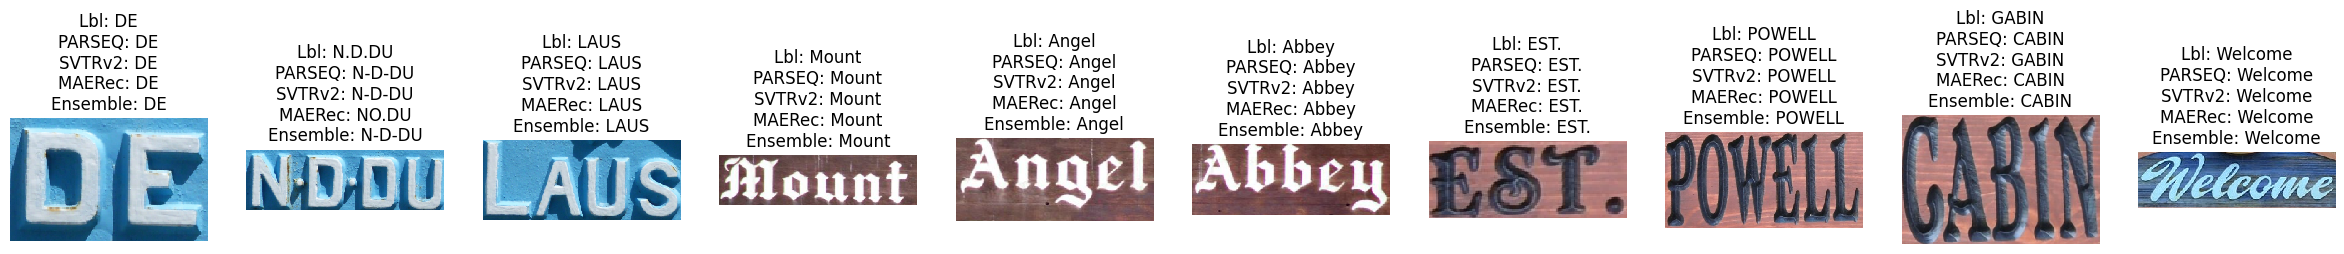

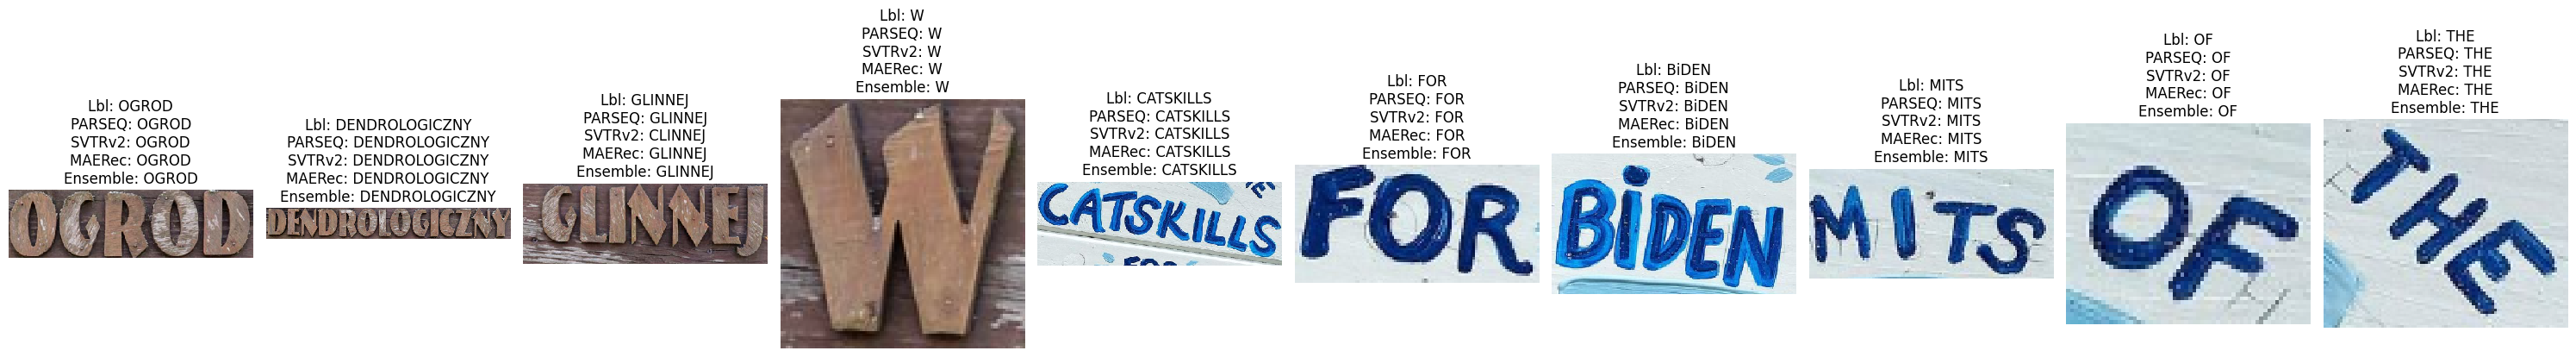

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

index = np.random.randint(len(results))
amount = 10

print(index)

for i in range(2):
    valid_indices = range(index + amount * i, index + amount * (i + 1))

    _, axes = plt.subplots(nrows=1, ncols=len(valid_indices), figsize=(30, 12))

    if len(valid_indices) == 1:
        axes = [axes]

    for ax, idx in zip(axes, valid_indices):
        # Load image using PIL
        img_path = results[idx].path # Assuming `results` contains image file paths
        img = Image.open(img_path).convert("RGB")  # Convert to RGB if needed

        ax.set_axis_off()
        ax.imshow(img, cmap="gray_r", interpolation="nearest")
        ax.set_title(
            f"Lbl: {results[idx].true}\n"
            f"PARSEQ: {models_predictions[0][idx].pred}\n"
            f"SVTRv2: {models_predictions[1][idx].pred}\n"
            f"MAERec: {models_predictions[2][idx].pred}\n"
            f"Ensemble: {results[idx].pred}"
        )

plt.tight_layout()
plt.show()

In [ ]:
index = 73 # 1702
index = 2185

In [ ]:
results = ensemble.run(infer_items[index].path, [infer_items[index]])

Ensemble: 100%|██████████| 1/1 [00:00<00:00, 262.57it/s]

{'o': 0.9803751111030579, '&': 0.9855746030807495}


In [ ]:
results

[EnsemblePrediction(path=PosixPath('/content/WordArt-V1.5/testB/images/new17535.png'), true='BiRthDay！', models_preds=[EnsembleModelPrediction(pred='BiRtohDay!', confidence=(0.99470717, 0.9358532, 0.90849525, 0.9875295, 0.63435054, 0.99120635, 0.991239, 0.98853034, 0.9601198, 0.9913283)), EnsembleModelPrediction(pred='BiRtohDay!', confidence=(0.9969647526741028, 0.9930006265640259, 0.7662102580070496, 0.9708841443061829, 0.9803751111030579, 0.9939723610877991, 0.960171103477478, 0.9952697157859802, 0.9844905734062195, 0.9987519979476929)), EnsembleModelPrediction(pred='BiRt&hDay!', confidence=(0.9960964322090149, 0.9588060975074768, 0.7814188003540039, 0.9753745198249817, 0.9855746030807495, 0.9855746030807495, 0.9742899537086487, 0.9924347400665283, 0.9996066689491272, 0.9952829480171204))], pred='BiRthDay!', confidence=(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))]

2185


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65281 (\N{FULLWIDTH EXCLAMATION MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


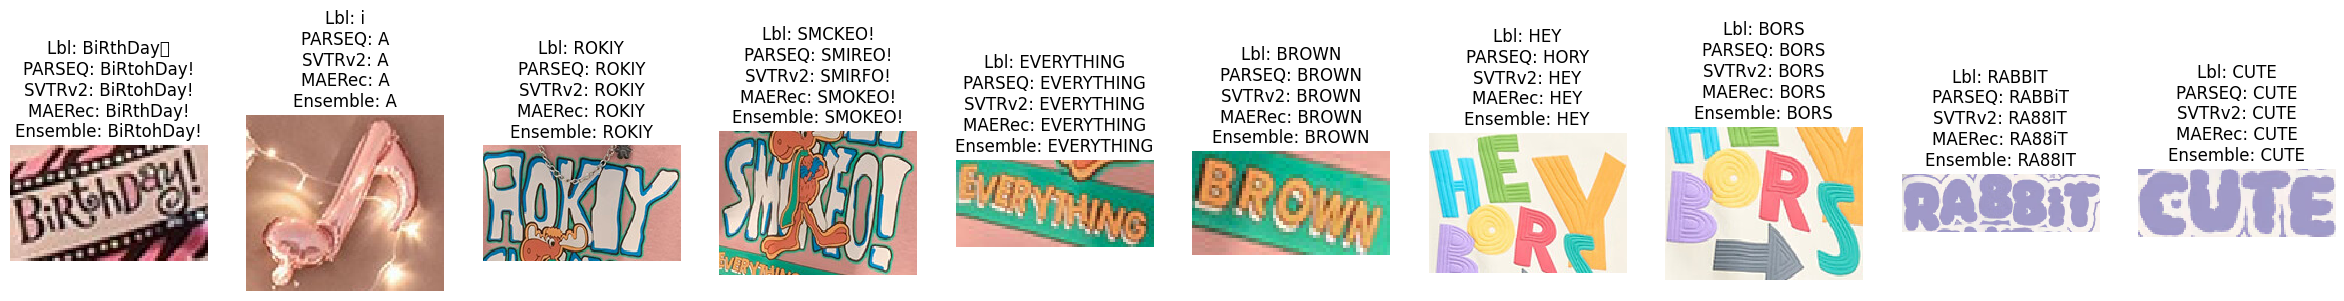

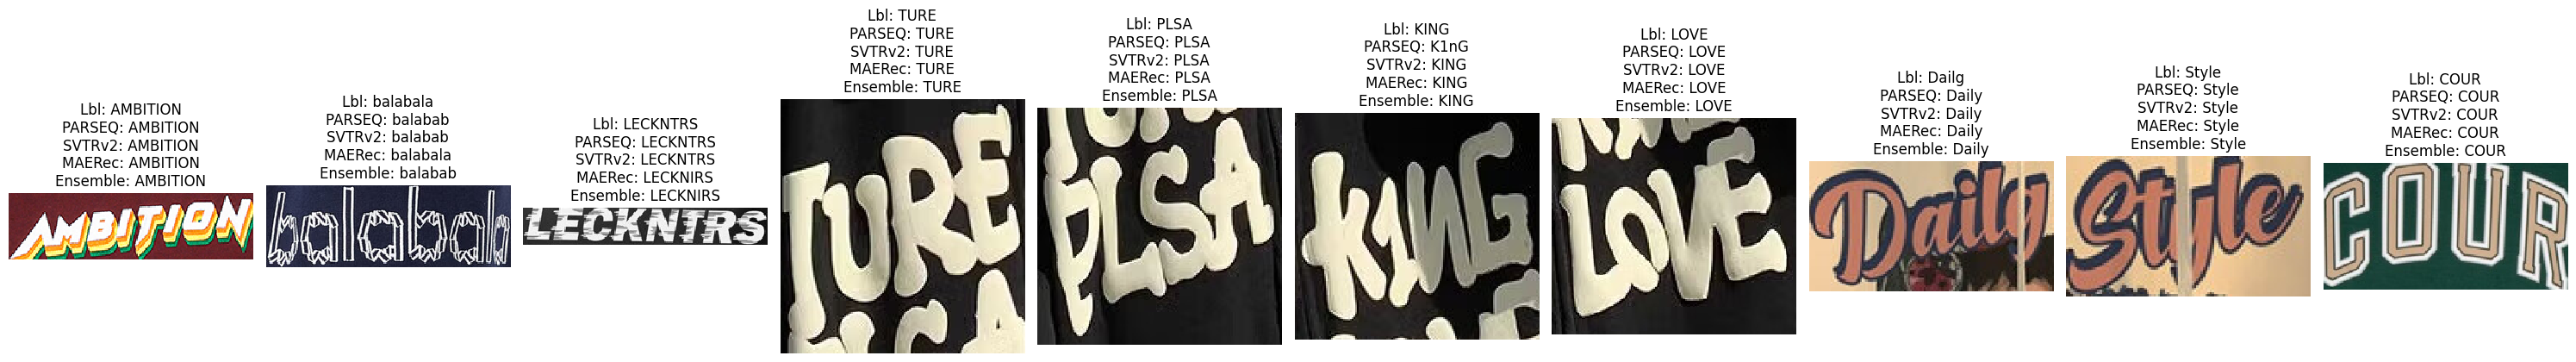

In [ ]:
# index = np.random.randint(len(results))
amount = 10

print(index)

for i in range(2):
    valid_indices = range(index + amount * i, index + amount * (i + 1))

    _, axes = plt.subplots(nrows=1, ncols=len(valid_indices), figsize=(30, 12))

    if len(valid_indices) == 1:
        axes = [axes]

    for ax, idx in zip(axes, valid_indices):
        # Load image using PIL
        img_path = results[idx].path # Assuming `results` contains image file paths
        img = Image.open(img_path).convert("RGB")  # Convert to RGB if needed

        ax.set_axis_off()
        ax.imshow(img, cmap="gray_r", interpolation="nearest")
        ax.set_title(
            f"Lbl: {results[idx].true}\n"
            f"PARSEQ: {models_predictions[0][idx].pred}\n"
            f"SVTRv2: {models_predictions[1][idx].pred}\n"
            f"MAERec: {models_predictions[2][idx].pred}\n"
            f"Ensemble: {results[idx].pred}"
        )

plt.tight_layout()
plt.show()

In [ ]:
# import itertools

# def ensemble(models_predictions: list[list[Prediction]]) -> list[Prediction]:
#     """
#     Align predictions using Needleman–Wunsch and vote per character weighted by confidence.
#     """
#     # Transpose: group predictions per sample
#     predictions_per_sample = list(map(list, zip(*models_predictions)))

#     results: list[Prediction] = []

#     for predictions in tqdm.tqdm(predictions_per_sample, desc="Ensemble"):
#         # Pick the first model’s prediction as reference
#         ref_pred = predictions[0].pred
#         aligned = [ref_pred]

#         # Align every other model prediction to the reference
#         for p in predictions[1:]:
#             ref_aligned, pred_aligned = needleman_wunsch(ref_pred, p.pred)
#             ref_pred = ref_aligned  # update ref to include possible new gaps
#             # re-align previous ones to the updated reference
#             aligned = [
#                 needleman_wunsch(ref_pred, a)[1] for a in aligned
#             ] + [pred_aligned]

#         aligned_preds = aligned
#         L = len(aligned_preds[0])

#         # Weighted majority voting per aligned character
#         combined = ""
#         for i in range(L):
#             char_conf: dict[str, float] = {}
#             for model_i, p in enumerate(predictions):
#                 c = aligned_preds[model_i][i]
#                 if c == "-":
#                     continue
#                 conf = p.confidence[min(i, len(p.confidence) - 1)]
#                 char_conf[c] = char_conf.get(c, 0.0) + conf
#             if char_conf:
#                 combined += max(char_conf, key=lambda c: char_conf[c])

#         results.append(
#             Prediction(
#                 path=predictions[0].path,
#                 true=predictions[0].true,
#                 pred=combined,
#                 confidence=(1.0,) * len(combined),
#             )
#         )

#     return results

In [ ]:
# def ensemble_predictions(
#     all_model_preds: list[list[Prediction]],
#     dictionary: set[str] | None = None,
#     calc_similarity_degree: typing.Callable | None = None,
#     low_conf_threshold: float = 0.7
# ) -> tuple[list[Prediction], dict[str, float]]:
#     """
#     Perform ensemble prediction across N OCR models using PredictionResult dataclass.

#     Args:
#         all_model_preds: List of model prediction lists (one list per model).
#         dictionary: Optional set of valid words for correction.
#         calc_similarity_degree: Optional callable for post-processing correction.
#         low_conf_threshold: Threshold below which characters are considered low-confidence.

#     Returns:
#         (ensembled_predictions, results_dict)
#     """
#     num_models = len(all_model_preds)
#     model_names = [f"Model_{i+1}" for i in range(num_models)]
#     total_samples = len(all_model_preds[0])

#     ensemb_preds: list[Prediction] = []

#     for preds_per_sample in tqdm.tqdm(zip(*all_model_preds), desc="Testing ensemble", total=total_samples):
#         # Each preds_per_sample = tuple of PredictionResult (one per model)
#         model_labels = [p.pred for p in preds_per_sample]
#         model_confs = [p.confidence for p in preds_per_sample]

#         # Detect positions with disagreement
#         max_len = max(len(lbl) for lbl in model_labels)
#         different_indexes = [
#             i for i in range(max_len)
#             if len({lbl[i] if i < len(lbl) else None for lbl in model_labels}) > 1
#         ]

#         # Compute model scores
#         model_scores = []
#         for conf in model_confs:
#             if different_indexes:
#                 vals = [conf[i] for i in different_indexes if i < len(conf)]
#             else:
#                 vals = conf
#             score = min(vals) if vals else 0.0
#             model_scores.append(score)

#         # Choose best model (highest confidence score)
#         best_model_idx = max(range(num_models), key=lambda i: model_scores[i])
#         best_pred = preds_per_sample[best_model_idx]
#         ensemb_label = best_pred.pred
#         ensemb_conf = best_pred.confidence

#         # Optional dictionary correction
#         if dictionary and calc_similarity_degree:
#             has_low_conf = any(c < low_conf_threshold for c in ensemb_conf)
#             filtered = [(ch.lower(), c) for ch, c in zip(ensemb_label, ensemb_conf) if ch.isalpha()]

#             if filtered:
#                 letters, confs = map(list, zip(*filtered))
#                 word = "".join(letters)
#                 if has_low_conf and word not in dictionary and len(word) > 3:
#                     lens = [len(lbl) for lbl in model_labels]
#                     post_pred = calc_similarity_degree(word, confs, dictionary, 0.6, min(lens), max(lens))
#                     if post_pred:
#                         fixed = ""
#                         used = 0
#                         for ch in ensemb_label:
#                             if not ch.isalpha():
#                                 fixed += ch
#                                 continue
#                             if used >= len(post_pred):
#                                 continue
#                             fixed += post_pred[used].upper() if ch.isupper() else post_pred[used].lower()
#                             used += 1
#                         ensemb_label = fixed

#         ensemb_preds.append(Prediction(
#             path=best_pred.path,
#             true=best_pred.true,
#             pred=ensemb_label,
#             confidence=tuple(ensemb_conf)
#         ))

#     # --- Evaluation ---
#     results = {}
#     total = total_samples
#     for name, model_preds in zip(model_names, all_model_preds):
#         correct = sum(p.pred == p.true for p in model_preds)
#         results[name] = correct / total * 100.0

#     ensemb_correct = sum(p.pred == p.true for p in ensemb_preds)
#     results["Ensemble"] = ensemb_correct / total * 100.0

#     print("\n")
#     for name, acc in results.items():
#         print(f"{name:<10} {acc:.2f}%")

#     return ensemb_preds, results

In [ ]:
# results = ensemble_predictions(models_predictions)[0]

Testing ensemble: 100%|██████████| 3000/3000 [00:00<00:00, 67982.30it/s]



Model_1    80.63%
Model_2    80.93%
Model_3    80.53%
Ensemble   82.00%


In [ ]:
# align both words and them apply voting per confidence weighthed on the score and corrected on a factor per model

In [ ]:
# Use Needleman–Wunsch for words alignment
# Calculate via confidence weighted on chars
# Calibrate each model confidence by a factor (better comparison)
# Fazer finetuning para cada modelo + comparar erros entre modelos raw e tuned (pode servir com extra no ensemble)
# Analisar erros do ensemble com finetuning sobre validacao e fazer data augmentation

In [ ]:
# Fazer classe Dataset com properties train, validation e test (cada um possui path e items (path + label))